<a href="https://colab.research.google.com/github/yuvalofek/FinancialSignalProcessing/blob/main/FSP_PS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt 

# Data

##Farma-French

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [ ]:
!wget -O 48_IP.zip http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_daily_CSV.zip

#for indexing
leng = 49624

#Getting the column names
cols = pd.read_csv('48_IP.zip',
                 skiprows = 9,
                 skipfooter = leng+4,
                 engine = 'python',
                 compression = 'zip') 
cols =  [col.replace(' ', '') for col in cols.columns.to_list()]
cols[0] = 'Date'

#Getting the values
ff = pd.read_csv('48_IP.zip',
                      names = cols,
                      skiprows = 25000, 
                      skipfooter = 3,
                      na_values = [' -99.99'],
                      engine = 'python',
                      compression = 'zip')

#Formatting the date
ff['Year'] = ff['Date'].astype(str).str[:4].astype(int)
#ff['Month'] = ff['Date'].astype(str).str[4:6].astype(int)
#ff['day']  = ff['Date'].astype(str).str[6:].astype(int)
ff = ff.drop('Date', 1)

#Selecting the date range we care about
ff = ff[(ff['Year'] >=2010) & (ff['Year']<=2019)]
ff.reset_index(drop = True, inplace = True)

ff.head()

--2020-10-12 19:37:27--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_daily_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.172.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.172.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3850438 (3.7M) [application/x-zip-compressed]
Saving to: ‘48_IP.zip’

48_IP.zip           100%[===================>]   3.67M  1.05MB/s    in 3.6s    

2020-10-12 19:37:30 (1.03 MB/s) - ‘48_IP.zip’ saved [3850438/3850438]



,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other,Year
0,1.61,1.65,0.75,0.71,2.03,4.24,3.37,3.33,2.29,1.43,1.71,1.08,1.96,3.19,2.25,3.10,2.80,2.57,4.59,2.99,2.92,2.27,3.02,2.18,2.45,2.96,6.00,4.96,6.51,4.45,1.03,2.52,1.56,2.29,2.20,1.79,1.22,1.91,2.22,1.15,1.86,1.19,0.81,1.49,1.90,3.21,2.18,2.14,2010
1,1.69,0.18,0.18,-0.08,-0.21,-0.43,0.18,-0.15,-0.28,1.15,-0.41,-0.45,-0.42,1.62,-0.84,0.02,-0.76,1.24,0.34,0.01,0.01,1.64,2.18,0.03,-0.67,0.73,1.64,2.46,3.96,1.43,-1.14,-0.18,-1.14,-0.50,0.23,0.17,0.21,-0.07,-0.41,-0.01,0.06,0.26,-0.31,-0.75,-0.44,-0.02,-0.62,0.27,2010
2,-0.54,-0.22,1.08,0.03,0.70,-1.08,0.34,1.24,-0.12,1.39,-0.07,0.46,0.45,0.19,-0.65,-1.24,-0.24,0.65,2.84,-0.09,0.62,0.49,0.73,0.77,-1.46,2.68,4.64,3.98,3.75,1.34,0.34,-0.67,0.48,0.05,0.23,-0.15,0.33,-0.36,0.16,-0.86,-0.08,0.75,-0.42,-0.29,-0.55,0.76,-0.06,0.33,2010
3,1.49,0.24,-1.49,-0.15,0.11,1.20,1.03,2.42,2.61,0.19,1.04,0.59,1.60,0.73,1.32,1.55,1.82,3.10,0.89,0.91,1.14,1.02,1.00,0.75,1.00,-0.95,1.73,-0.75,-0.66,0.58,-0.35,0.50,1.20,0.80,0.16,0.28,0.70,0.65,-1.06,-0.07,0.44,1.26,0.82,1.94,1.33,0.54,1.05,0.49,2010
4,0.32,-0.19,0.22,-1.37,0.31,0.19,-0.47,-0.14,0.37,0.41,0.45,0.87,1.66,1.66,-0.63,-0.46,1.22,0.42,2.35,2.42,1.61,1.27,1.75,0.25,0.22,0.01,0.35,2.14,2.78,0.85,0.12,-0.46,-0.25,0.88,0.66,0.81,1.56,0.93,0.66,0.52,0.62,0.38,0.47,1.18,0.44,0.51,0.65,0.18,2010


##S&P500

Found on finance.yahoo.com

In [ ]:
def extract(path, year_range = (2010,2019)):
  yr_bg, yr_end = year_range

  df = adobe = pd.read_csv(path)
  df['Year'] = df['Date'].str[:4].astype(int)
  df['Month'] = df['Date'].str[5:7].astype(int)
  df = df.drop('Date', 1)
  df =  df[(df['Year'] >=yr_bg) & (df['Year']<=yr_end)]
  return df
Snp = extract('^GSPC.csv')

Snp.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month
23,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,2010,1
24,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,2010,1
25,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,2010,1
26,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,2010,1
27,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,2010,1


### 5 Companies of interest:


*   Adobe Inc.
*   Apple Inc.
*   AT&T Inc.
*   Nike, Inc.
*   Microsoft Corp.

Found in finance.yahoo.com, downloaded as seperate files

In [ ]:
adobe = extract('ADBE.csv')
apple = extract('AAPL.csv')
att = extract('T.csv')
nike = extract('NKE.csv')
msft = extract('MSFT.csv')

##USD LIBOR rate for 1 year maturity

https://www.macrotrends.net/2515/1-year-libor-rate-historical-chart

In [ ]:
#Averaging rate for each of the years of interest in ascending order (2010-2019)
LIBOR_rate = [0.92, 0.83, 1.01, 0.68, 0.56, 0.79, 1.38, 1.79, 2.76,2.37]
LIBOR_daily = [r/360 for r in LIBOR_rate]
LIBOR_monthly = [r/12 for r in LIBOR_rate]

##Splitting by year

In [ ]:
def split_year(df, name):
  for yr in df.Year.unique().tolist():
    (df[(df['Year'] == yr)]).drop('Year',1).to_csv(name+str(yr), index = False)

split_year(ff, 'Farma-French_')
split_year(Snp, 'S&P500_')
split_year(adobe, 'Adobe_')
split_year(apple, 'Apple_')
split_year(att, 'AT&T_')
split_year(nike, 'Nike_')
split_year(msft, 'Microsoft_')
#split_year(mcd, 'MCD_')

#I forgo saving the USD LIBOR rate in a seperate file as it isn't a large array 


# Analysis

## Basic Markowitz Portfolio Analysis:

In [ ]:
def get_MVP_M(df, R):
  m = df.mean().to_numpy().reshape(-1,1)
  C = df.cov().to_numpy()
  C_inv = np.linalg.inv(C)
  one = np.ones(m.shape)

  sig_mvp = 1/np.sqrt(one.T@C_inv@one)
  w_mvp = (sig_mvp**2)*C_inv@one
  mu_mvp = m.T@w_mvp

  m_ex = m-R
  w_m = (C_inv@m_ex)/(one.T@C_inv@m_ex)
  sig_m = np.sqrt(w_m.T@C@w_m)
  mu_m = m.T@w_m 

  return (w_mvp, sig_mvp, mu_mvp), (w_m, sig_m, mu_m), m, C_inv, C
  

def bullet_sig(m, C_inv, mu_vect):
  m_ = np.concatenate((m, np.ones(shape=m.shape)), axis = 1)
  B = m_.T@C_inv@m_
  B_inv = np.linalg.inv(B)

  G = B_inv@m_.T@C_inv@m_@B_inv
  a = G[0,0]

  sig = np.sqrt(a*(mu_vect+G[1,0]/a)**2+np.linalg.det(G)/a)
  return sig

def w2noshort(w):
  w2 = np.copy(w)
  w2[w2<0] = 0  
  return w2/sum(w2)

def table_params(mu_v, mu_m, sig_v, sig_m, R):
  mu_v = mu_v.reshape(-1)
  N = mu_v.shape[0]
  
  beta = (mu_v-R)/(mu_m-R)
  corr = beta*sig_m**2
  sys_risk =(beta*sig_m)**2
  div_risk = sig_v**2 - sys_risk

  return corr, beta, sys_risk, div_risk


def year_analysis(path, R, TwoPortfNames, N=100):

  #48 portfolio
  df = pd.read_csv(path)
  (w_mvp, sig_mvp, mu_mvp), (w_m, sig_m, mu_m), m, C_inv, C = get_MVP_M(df, R)
  mu_vals = np.linspace(mu_mvp, mu_m+0.2, N).reshape(-1)
  sig = bullet_sig(m, C_inv, mu_vals)

  print('R<mu_MVP:', R<mu_mvp)
  #2 Portfolios only
  portf1, portf2 = TwoPortfNames
  two_portf = df[[portf1, portf2]]
  (w_mvp2, sig_mvp2, mu_mvp2), (w_m2, sig_m2, mu_m2), m2, C_inv2, _ = get_MVP_M(two_portf, R)
  mu_vals2 = np.linspace(mu_mvp2, mu_m2, N).reshape(-1)
  sig2 = bullet_sig(m2, C_inv2, mu_vals2)
  
  #No Shorting
  w_mvp_no_short = w2noshort(w_mvp)
  w_m_no_short = w2noshort(w_m)
  mu_mvp_no_short = m.T@w_mvp_no_short
  mu_m_no_short = m.T@w_m_no_short
  sigs_no_short = bullet_sig(m, C_inv, [mu_mvp_no_short, mu_m_no_short])

  ###Annotated Bullet plot
  plt.figure(figsize = (7,7))
  plt.plot(sig, mu_vals)
  plt.title('Markowitz Portfolio Analysis - '+path[-4:], fontsize = 18)
  plt.xlabel(r'$\sigma$', fontsize = 14)
  h = plt.ylabel(r'$\mu$', fontsize = 14)
  h.set_rotation(0)
  x_min, x_mx = plt.xlim()
  plt.xlim((0,x_mx))

  #labeling
  plt.scatter(sig_mvp, mu_mvp, c = 'k')
  plt.scatter(sig_m,  mu_m, c = 'r')
  plt.scatter(sigs_no_short[0],  mu_mvp_no_short, c = 'y')
  plt.scatter(sigs_no_short[1],  mu_m_no_short, c = 'm')

  #(0,R) to (sig_m, mu_m) line
  plt.plot([0, sig_m.reshape(-1)], [R, mu_m.reshape(-1)])
  #efficient frontier for 2 portfolios
  plt.plot(sig2, mu_vals2)

  plt.legend(['48-portfolio efficient frontier',
              '(0,R) -> $(\sigma_M, \mu_M)$',
              '2-portfolio efficient frontier',
              'MVP', 
              'Market', 
              'MVP - No Shorting',
              'Market - No Shorting'
              ])
  plt.show()


  ###corr, beta, and risk table
  mu_values = np.array([mu_mvp,
                        mu_mvp_no_short,
                        mu_m_no_short,
                        mu_mvp2,
                        mu_m2])
  sig_values = np.array([sig_mvp,
                        sigs_no_short[0], 
                        sigs_no_short[1],
                        sig_mvp2,
                        sig_m2
                        ])

  corr, beta, sys_risk, div_risk = table_params(mu_values, mu_m, sig_values, sig_m, R)

  #Formatting the table
  corr = corr.reshape(-1).tolist()
  beta = beta.reshape(-1).tolist()
  sys_risk = sys_risk.reshape(-1).tolist()
  div_risk = div_risk.reshape(-1).tolist()

  corr.insert(0, 'Correlation Coefficient')
  beta.insert(0, 'Beta')
  sys_risk.insert(0,'Systematic Risk')
  div_risk.insert(0, 'Diversifiable Risk')
  inp = [corr, beta, sys_risk,div_risk]
  header = ['{MVP}',
            '{MVP-NoShort}',
            '{M-NoShort}',
            '{MVP-2portfolios}',
            '{M-2portfolios}']
  t = tabulate(inp, headers =header ,tablefmt='orgtbl')
  print(t, '\n')


  ### Eigenvalue stuff
  evals, _ = np.linalg.eig(C)
  evals = np.sort(evals)
  evals = evals[::-1]
  print('All evals greater than zero:', all(evals>0))
  cond_num = evals[0]/evals[-1]
  print('Condition Number:', cond_num)

  plt.figure(figsize = (7,7))
  plt.plot(evals)
  plt.title('Eigenvalues of the Covariance Matrix - '+path[-4:], fontsize = 18)
  plt.xlabel(r'$\lambda_i$', fontsize = 14)
  plt.yscale('log')
  h = plt.ylabel(r'log$(\lambda)$', fontsize = 14)
  h.set_rotation(0)
  plt.xlim((0,48))
  plt.show()

###2010

R<mu_MVP: [[ True]]


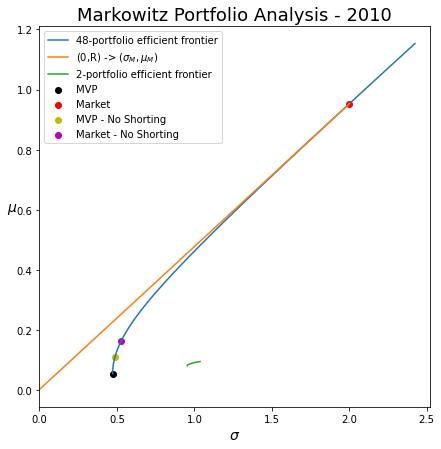

|                         |     {MVP} |   {MVP-NoShort} |   {M-NoShort} |   {MVP-2portfolios} |   {M-2portfolios} |
|-------------------------+-----------+-----------------+---------------+---------------------+-------------------|
| Correlation Coefficient | 0.223358  |       0.452846  |      0.678123 |           0.332393  |         0.392233  |
| Beta                    | 0.0557942 |       0.11312   |      0.169393 |           0.0830309 |         0.0979786 |
| Systematic Risk         | 0.0124621 |       0.0512257 |      0.11487  |           0.0275989 |         0.0384304 |
| Diversifiable Risk      | 0.210896  |       0.172132  |      0.108488 |           0.195759  |         0.184927  | 

All evals greater than zero: True
Condition Number: 1845.9880867600216


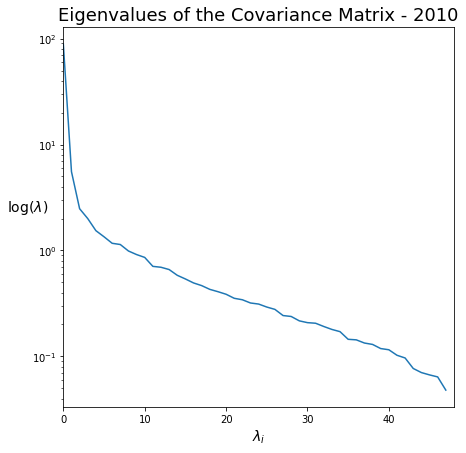

In [ ]:
R = LIBOR_daily[0]
year_analysis('Farma-French_2010', R,  ('Guns', 'Food'))

We see that the line from (0,R) to ($\sigma_M$, $\mu_M$) is indeed tangent to the bullet curve at the Market point. 

We also see that there seems to be a sudden drop or threshold effect in the eigenvalue plot. This is in line with the condition number.  

###2012

R<mu_MVP: [[ True]]


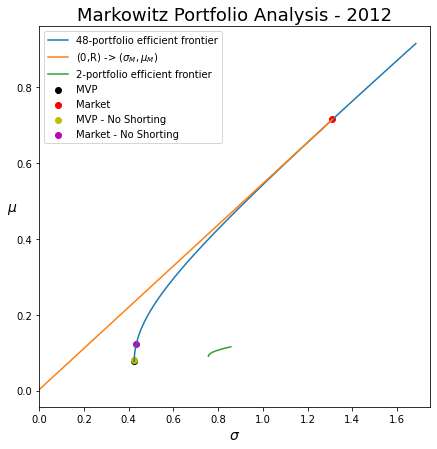

|                         |     {MVP} |   {MVP-NoShort} |   {M-NoShort} |   {MVP-2portfolios} |   {M-2portfolios} |
|-------------------------+-----------+-----------------+---------------+---------------------+-------------------|
| Correlation Coefficient | 0.180408  |       0.190421  |     0.291681  |           0.212082  |         0.271932  |
| Beta                    | 0.10487   |       0.11069   |     0.169552  |           0.123282  |         0.158072  |
| Systematic Risk         | 0.0189193 |       0.0210778 |     0.0494549 |           0.0261458 |         0.0429848 |
| Diversifiable Risk      | 0.161488  |       0.15933   |     0.130953  |           0.154262  |         0.137423  | 

All evals greater than zero: True
Condition Number: 1155.5187061163535


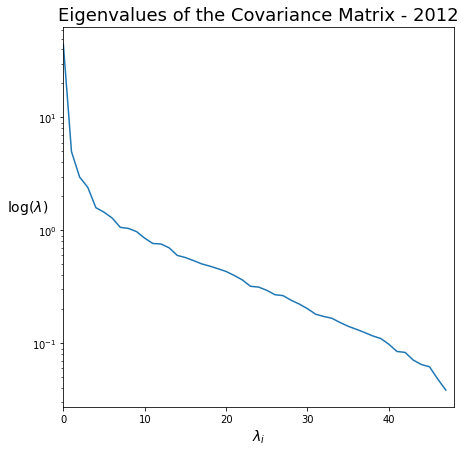

In [ ]:
R = LIBOR_daily[2]
year_analysis('Farma-French_2012', R,  ('Guns', 'Food'))

Very close to the conclusions\comments  above. We see that the eigenvalue drop is less steep than before, and also that the condition number is smaller. 

###2014

R<mu_MVP: [[ True]]


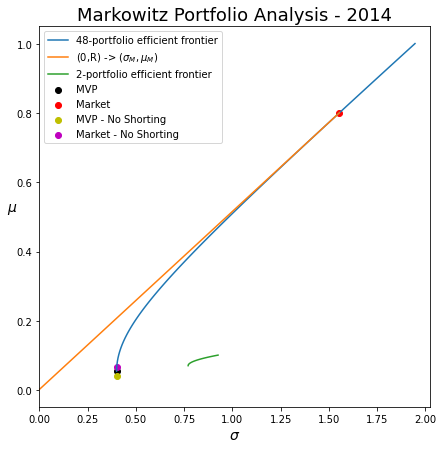

|                         |     {MVP} |   {MVP-NoShort} |   {M-NoShort} |   {MVP-2portfolios} |   {M-2portfolios} |
|-------------------------+-----------+-----------------+---------------+---------------------+-------------------|
| Correlation Coefficient | 0.160342  |      0.113913   |     0.193442  |           0.208275  |         0.300386  |
| Beta                    | 0.0663556 |      0.0471418  |     0.0800537 |           0.0861921 |         0.124311  |
| Systematic Risk         | 0.0106396 |      0.00537008 |     0.0154857 |           0.0179516 |         0.0373413 |
| Diversifiable Risk      | 0.149702  |      0.154972   |     0.144856  |           0.14239   |         0.123     | 

All evals greater than zero: True
Condition Number: 1022.2857860461596


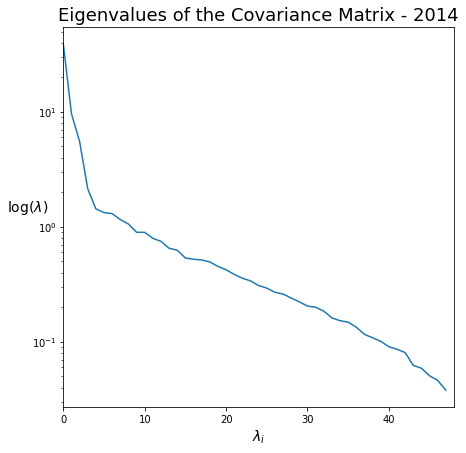

In [ ]:
R = LIBOR_daily[4]
year_analysis('Farma-French_2014', R,  ('Guns', 'Food'))

###2017

R<mu_MVP: [[ True]]


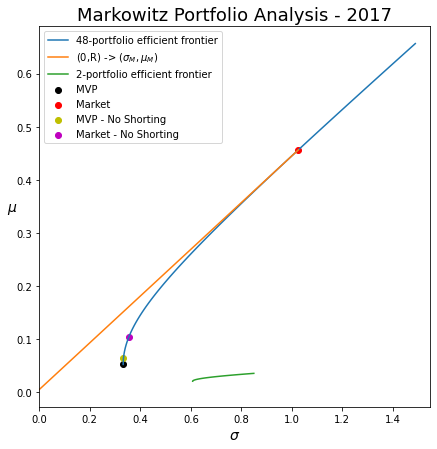

|                         |     {MVP} |   {MVP-NoShort} |   {M-NoShort} |   {MVP-2portfolios} |   {M-2portfolios} |
|-------------------------+-----------+-----------------+---------------+---------------------+-------------------|
| Correlation Coefficient | 0.110317  |       0.138464  |     0.231139  |           0.0362332 |        0.0708962  |
| Beta                    | 0.104751  |       0.131477  |     0.219477  |           0.034405  |        0.067319   |
| Systematic Risk         | 0.0115557 |       0.0182048 |     0.0507296 |           0.0012466 |        0.00477266 |
| Diversifiable Risk      | 0.098761  |       0.092112  |     0.0595871 |           0.10907   |        0.105544   | 

All evals greater than zero: True
Condition Number: 441.1522867244662


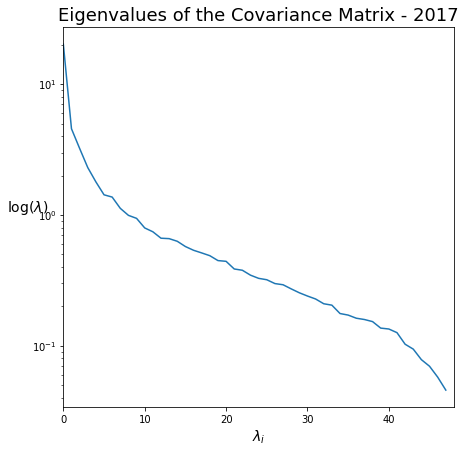

In [ ]:
R = LIBOR_daily[7]
year_analysis('Farma-French_2017', R,  ('Guns', 'Food'))

###Comments 
The point that maximizes $\beta$ is the Market point. $\beta = cov(K_V, K_M)/\sigma^2_M$, so for a fixed market point we see that $\beta$ is maximized when $K_V = K_M$, for which it equals $1$. This cannot really be achieved with only 2 porfolios and without short selling, as the efficient frontier generated will not necessarily include the market price. We can re-write $\beta$ as $\beta = (\mu_V - R)/(\mu_M - R)$ as the ratio of the expected returns. For beta to be maximized we see that we need $\mu_V = \mu_M$. This is very similar to our earlier conclusion, but it gives us more intuition as to where the point we are looking for lies. We see that we want the closest $\mu$ value to $\mu_M$, which can only be the market point for the two porfolios without short selling. 

We see that the results are comparable across the years picked. We see that the parameters that make up the Markowitz bullet move around from year to year (by this I mean the points themselves), but the relationships between all of the parameters stay the same (the line is still tangential, we are still working with a hyperbola, the 2 portfolios are always inside the bullet, etc.). One other thing to note is that I didn't encounter a year where $R>\mu_{MVP}$. 

The one odd thing I saw was in year 2014. The the no-shorting approximation we made for the MVP yielded a point bellow the original MVP (by this I mean in the bottom half of the hyperbola as opposed to the top half where it should be). This is odd as the MVP should be the 'vertex' of the hyperbola and in this scenario this could not be the case (assuming we stay on the original Markowitz bullet). I believe this happened because of the approximation itself, so I don't find it too odd that something like this happened (the values was close to the MVP, but still a bit under). 



##S&P500 and Stock Data

In [ ]:
def returns(df):
  ''' Get the daily returns of the df'''
  diff = df['Adj Close'].diff().drop(0).to_numpy()
  Sx = (df['Adj Close'].drop(df.tail(1).index)).to_numpy()
  K = diff/Sx
  return pd.Series(K)

def returns_monthly(df):
  '''return the monthly returns of the df'''
  months = df.groupby('Month').first().append(df.tail(1)).drop('Month', 1)
  diff = months['Adj Close'].diff().to_numpy()[1:]
  Sx = (months['Adj Close'].drop(months.tail(1).index)).to_numpy()
  K = diff/Sx
  return pd.Series(K)

def extract_year(year, returns):
  '''
  Read through the proper files and create a df with the daily returns of the 
  listed companies   
  '''
  SNP = {'S&P500': 'S&P500_'+str(year),
        'Adobe': 'Adobe_'+str(year),
        'Apple': 'Apple_'+str(year),
        'AT&T': 'AT&T_'+str(year),
        'Microsoft': 'Microsoft_'+str(year),
        'Nike': 'Nike_'+str(year),
        #'McDonalds': 'MCD_'+str(year)
        }
  for key, val in SNP.items():
    SNP[key] = returns(pd.read_csv(val))
  SNP = pd.DataFrame(SNP)
  return SNP

def extract_quarters(year):
    '''
  Read through the proper files and create a df with the monthly returns of the 
  listed companies   
  '''
  SNP = {'S&P500': 'S&P500_'+str(year),
        'Adobe': 'Adobe_'+str(year),
        'Apple': 'Apple_'+str(year),
        'AT&T': 'AT&T_'+str(year),
        'Microsoft': 'Microsoft_'+str(year),
        'Nike': 'Nike_'+str(year),
        #'McDonalds': 'MCD_'+str(year)
        }
  SNPK = {}
  ks = SNP.keys()
  for key, val in SNP.items():
    df = pd.read_csv(val)
    #column to denote the quarter
    df['Split'] = np.floor((df.Month-1)/3).astype(int)
    for i in range(4):
      #get returns for each quarter seperately
      SNPK[key+str(i)] = returns(df[df['Split'] == i].reset_index(drop = True))
  SNP = pd.DataFrame(SNPK)

  return SNP, ks

def daily_SNP(year, R, N = 100):
  '''
  Perform analysis to plot the efficient frontier or the upper side of the hyperbola
  also compute beta, and the risks and print them in a table
  '''
  SNP = extract_year(year, returns)
  mu_SP = SNP.iloc[:,0].mean()
  sig_SP = SNP.iloc[:,0].var()


  #No market price as R>mu_mvp
  (w_mvp, sig_mvp, mu_mvp), _, m, C_inv, C = get_MVP_M(SNP.iloc[:,1:], R)

  print('R<mu_MVP:', R<mu_mvp)
  mu_vals = np.linspace(mu_mvp, mu_mvp+0.004, N).reshape(-1)
  sig = bullet_sig(m, C_inv, mu_vals)



  ###Annotated Bullet plot
  plt.figure(figsize = (7,7))
  #plt.plot(sigs, mus)
  plt.plot(sig, mu_vals)
  plt.title('Daily Returns Analysis - '+str(year), fontsize = 18)
  plt.xlabel(r'$\sigma$', fontsize = 14)
  h = plt.ylabel(r'$\mu$', fontsize = 14)
  h.set_rotation(0)

  plt.scatter(np.sqrt(np.diag(C)), m)
  plt.scatter(sig_SP, mu_SP)
  plt.legend(['Efficient Frontier', 
              '($\sigma, \mu$) for the stocks',
              '($\sigma_{SP}, \mu_{SP}$)'
              ])
  plt.show()

  ### Table
  sigs = np.sqrt(np.diag(C))
  corr, beta, sys_risk, div_risk = table_params(m, mu_SP, sigs, sig_SP, R)

  stock_pts =[(sigs[i], m[i][0]) for i in range(len(m))]
  stock_pts.insert(0, (sig_SP, mu_SP))
  #Formatting the table
  beta = beta.reshape(-1).tolist()
  sys_risk = sys_risk.reshape(-1).tolist()
  div_risk = div_risk.reshape(-1).tolist()

  beta.insert(0, 'Beta_Year')
  sys_risk.insert(0,'Systematic Risk')
  div_risk.insert(0, 'Diversifiable Risk')
  inp = [beta, sys_risk,div_risk]
  header = SNP.columns[1:].to_list()
  t = tabulate(inp, headers =header ,tablefmt='orgtbl')
  stock_pts.insert(0, 'S&P and Stock Points, Year')
  print(t, '\n')
  return  beta, stock_pts



def monthly_SNP(year, R, N=100):
  '''
  Perform analysis to plot the efficient frontier or the upper side of the hyperbola
  also compute beta, and the risks and print them in a table
  -Monthly returns used
  '''
  SNP = extract_year(year, returns_monthly)
  mu_SP = SNP.iloc[:,0].mean()
  sig_SP = SNP.iloc[:,0].var()


  #No market price as R>mu_mvp
  (w_mvp, sig_mvp, mu_mvp), _, m, C_inv, C = get_MVP_M(SNP.iloc[:,1:], R)
  print('R<mu_MVP:', R<mu_mvp)

  #Efficient Frontier
  mu_vals = np.linspace(mu_mvp, mu_mvp+0.1, N).reshape(-1)
  sig = bullet_sig(m, C_inv, mu_vals)



  ###Annotated Bullet plot
  plt.figure(figsize = (7,7))
  #plt.plot(sigs, mus)
  plt.plot(sig, mu_vals)
  plt.title('Monthly Returns Analysis - '+str(year), fontsize = 18)
  plt.xlabel(r'$\sigma$', fontsize = 14)
  h = plt.ylabel(r'$\mu$', fontsize = 14)
  h.set_rotation(0)

  plt.scatter(np.sqrt(np.diag(C)), m)
  plt.scatter(sig_SP, mu_SP)
  plt.legend(['Efficient Frontier', 
              '($\sigma, \mu$) for the stocks',
              '($\sigma_{SP}, \mu_{SP}$)'
              ])
  plt.show()

  ### Table
  corr, beta, sys_risk, div_risk = table_params(m, mu_SP, np.sqrt(np.diag(C)), sig_SP, R)
  #Formatting the table
  beta = beta.reshape(-1).tolist()
  sys_risk = sys_risk.reshape(-1).tolist()
  div_risk = div_risk.reshape(-1).tolist()

  beta.insert(0, 'Beta')
  sys_risk.insert(0,'Systematic Risk')
  div_risk.insert(0, 'Diversifiable Risk')
  inp = [beta, sys_risk,div_risk]
  header = SNP.columns[1:].to_list()
  t = tabulate(inp, headers =header ,tablefmt='orgtbl')
  print(t, '\n')


def daily_in_4_SNP(year, R):
  '''
  Perform analysis for the data for a given year in quarters. 
  Present the beta and (mu,sigma) points for the data in a table
  '''
  quarterly, cols = extract_quarters(2010)
  num_cols = len(quarterly.columns)
  indexing = np.arange(num_cols)%4
  storage = {}
  for i in range(4):
    SNP = quarterly.loc[:,indexing == i]
    mu_SP = SNP.iloc[:,0].mean()
    sig_SP = SNP.iloc[:,0].var()
    (w_mvp, sig_mvp, mu_mvp), _, m, C_inv, C = get_MVP_M(SNP.iloc[:,1:], R)

    sigs = np.sqrt(np.diag(C))
    stock_pts =[(sigs[i], m[i][0]) for i in range(len(m))]
    stock_pts.insert(0, (sig_SP, mu_SP))
    
    _, beta, _, _7 = table_params(m, mu_SP,
                                                  np.sqrt(np.diag(C)), sig_SP, R)
    #Formatting the table
    beta = beta.reshape(-1).tolist()
    beta.insert(0, '')
    beta.insert(0, 'Beta, Quarter:' +str(i+1))
    stock_pts.insert(0, 'S&P and Stock Points, Quarter:' +str(i+1))

    storage['beta'+str(i)] = beta
    storage['pts'+str(i)] = stock_pts

  head = list(cols)
  head.insert(0, 'S&P500')
  inp = storage.values()
  t = tabulate(inp, headers =head ,tablefmt='orgtbl')
  print(t, '\n')

def SNP500_Analysis(year):
  '''
  Go through the analysis outlined in problem 2 of the homework for a given year
  '''
  R = int(str(year)[-1])
  print('DAILY for a year')
  beta_yr, stock_pts_yr =daily_SNP(year, LIBOR_daily[R])

  print('MONTHLY')
  monthly_SNP(year, LIBOR_monthly[R])

  print('DAILY in Quarters')
  ###Quarterly
  daily_in_4_SNP(year, LIBOR_daily[R])
  #reformatting (from above when we did the daily analysis for the entire year)
  beta = beta_yr[1:]
  beta.insert(0,'')
  beta.insert(0,'Beta, Year')
  print(tabulate([beta,stock_pts_yr], tablefmt='orgtbl'))
  

###2010

DAILY for a year
R<mu_MVP: [[False]]


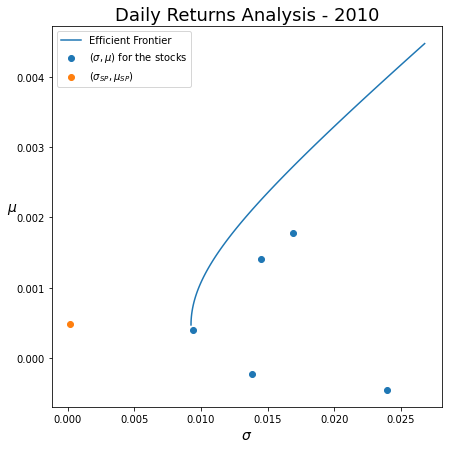

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta_Year          | 1.44757     | 0.37509     | 1.03656     | 1.34431     | 0.550924    |
| Systematic Risk    | 3.47971e-08 | 2.33633e-09 | 1.78424e-08 | 3.00099e-08 | 5.04019e-09 |
| Diversifiable Risk | 0.000575841 | 0.000284513 | 8.89498e-05 | 0.000191235 | 0.00020966  | 

MONTHLY
R<mu_MVP: [[False]]


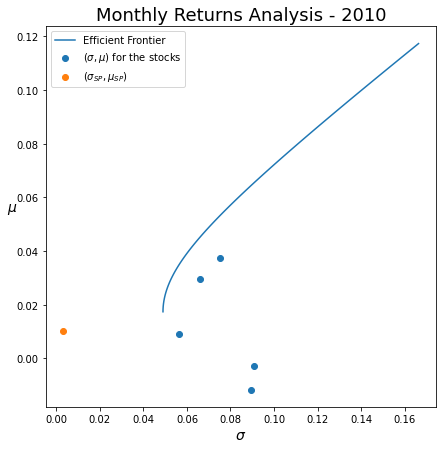

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta               | 1.32949     | 0.592699    | 1.01849     | 1.20013     | 0.707566    |
| Systematic Risk    | 1.87337e-05 | 3.72328e-06 | 1.09943e-05 | 1.52656e-05 | 5.30628e-06 |
| Diversifiable Risk | 0.00797859  | 0.00562639  | 0.00316802  | 0.00820425  | 0.00434359  | 

DAILY in Quarters
| S&P500                          | S&P500                                           | Adobe                                         | Apple                                         | AT&T                                           | Microsoft                                      | Nike                                           |
|---------------------------------+--------------------------------------------------+-----------------------------------------------+-----------------------------------------------+---

In [ ]:
SNP500_Analysis(2010)

###2016

DAILY for a year
R<mu_MVP: [[False]]


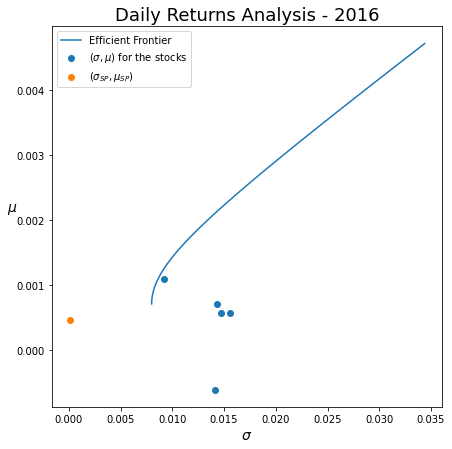

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta_Year          | 0.966833    | 0.965758    | 0.81254     | 0.925092    | 1.31431     |
| Systematic Risk    | 4.23751e-09 | 4.22809e-09 | 2.99293e-09 | 3.87951e-09 | 7.83071e-09 |
| Diversifiable Risk | 0.000241046 | 0.000217001 | 8.37167e-05 | 0.00020448  | 0.00019826  | 

MONTHLY
R<mu_MVP: [[False]]


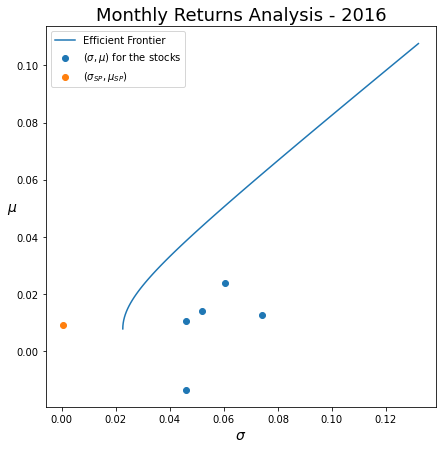

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta               | 0.988497    | 0.969817    | 0.861617    | 0.954136    | 1.21517     |
| Systematic Risk    | 3.47818e-07 | 3.34797e-07 | 2.64259e-07 | 3.24058e-07 | 5.25626e-07 |
| Diversifiable Risk | 0.00210194  | 0.00550293  | 0.00365612  | 0.00268684  | 0.00212106  | 

DAILY in Quarters
| S&P500                          | S&P500                                           | Adobe                                         | Apple                                         | AT&T                                           | Microsoft                                      | Nike                                           |
|---------------------------------+--------------------------------------------------+-----------------------------------------------+-----------------------------------------------+---

In [ ]:
SNP500_Analysis(2016)

###2019

DAILY for a year
R<mu_MVP: [[False]]


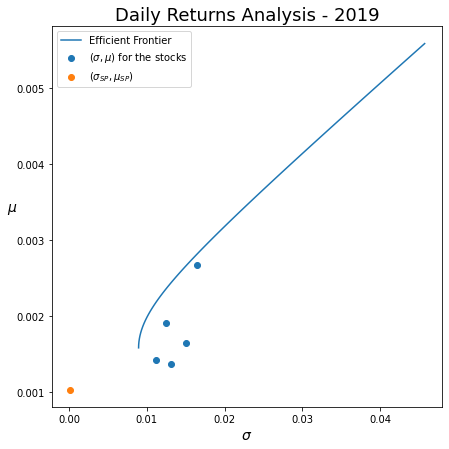

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta_Year          | 0.890442    | 0.705468    | 0.930633    | 0.84288     | 0.938824    |
| Systematic Risk    | 3.04528e-09 | 1.91148e-09 | 3.32639e-09 | 2.72865e-09 | 3.3852e-09  |
| Diversifiable Risk | 0.000225775 | 0.00027219  | 0.000125796 | 0.000156481 | 0.000170741 | 

MONTHLY
R<mu_MVP: [[False]]


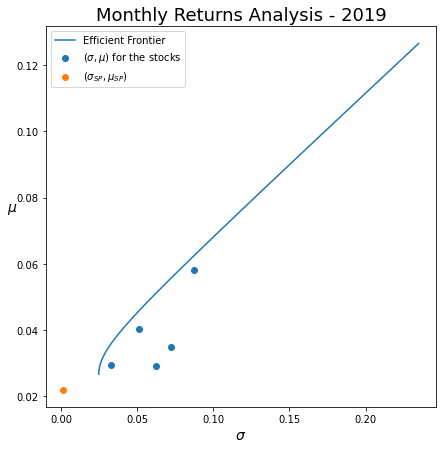

|                    |       Adobe |       Apple |        AT&T |   Microsoft |        Nike |
|--------------------+-------------+-------------+-------------+-------------+-------------|
| Beta               | 0.926465    | 0.794665    | 0.958038    | 0.896334    | 0.959111    |
| Systematic Risk    | 1.96073e-06 | 1.44254e-06 | 2.09665e-06 | 1.83527e-06 | 2.10135e-06 |
| Diversifiable Risk | 0.00518041  | 0.0076305   | 0.00109276  | 0.00258626  | 0.00389165  | 

DAILY in Quarters
| S&P500                          | S&P500                                           | Adobe                                         | Apple                                         | AT&T                                           | Microsoft                                      | Nike                                           |
|---------------------------------+--------------------------------------------------+-----------------------------------------------+-----------------------------------------------+---

In [ ]:
SNP500_Analysis(2019)

### Comments
Comparing the daily analysis by year and the monthly analysis we see some substantial differences. For one, the sigma scale for the monthly analysis is much higher than for the daily. This also shows up in the diversifiable and systematic risk, the monthly risks are over an order of magnitude higher than the daily risk values. This makes sense as we were doing a monthly returns where the data points are further apart in time from each other, and therefore there is more variation in the data points we get. 

For the daily returns analyzed in the 4 quarters, I didn't see things too distinctly different from the daily return analysis performed on the entire year. We saw some fluctuations in the values of the stock points and the betas, but not by significant amounts. 